# Sensitivity

Material courtesy of Joseph Near, University of Vermont

As we mentioned when we dicussed the Laplace mechanism, the amount of noise necessary to ensure differential privacy for a given query depends on the *sensitivity* of the query. Roughly speaking, the sensitivity of a function reflects the amount the function's output will change when its input changes. Recall that the Laplace mechanism defines a mechanism $F(x)$ as follows:

\begin{align}
F(x) = f(x) + \textsf{Lap}(\frac{s}{\epsilon})
\end{align}

where $f(x)$ is a deterministic function (the query), $\epsilon$ is the privacy parameter, and $s$ is the sensitivity of $f$.

For a function $f : \mathcal{D} \rightarrow \mathbb{R}$ mapping datasets ($\mathcal{D}$) to real numbers, the *global sensitivity* of $f$ is defined as follows:

\begin{align}
GS(f) = \max_{x, y: d(x,x') <= 1} |f(x) - f(x')|
\end{align}

Here, $d(x, x')$ represents the *distance* between two datasets $x$ and $x'$, and we say that two datasets are *neighbors* if their distance is 1 or less. How this distance is defined has a huge effect on the definition of privacy we obtain, and we'll discuss the distance metric on datasets in detail later on.

The definition of global sensitivity says that for *any two* neighboring datasets $x$ and $x'$, the difference between $f(x)$ and $f(x')$ is at most $GS(f)$. This measure of sensitivity is called "global" because it is independent of the actual dataset being queried (it holds for *any* choice of neighboring $x$ and $x'$). 

(*Recall*: Another measure of sensitivity, called *local sensitivity*, fixes one of the datasets to be the one being queried. For now, when we say "sensitivity," we mean global sensitivity.)

## Calculating Sensitivity

How do we determine the sensitivity of a particular function of interest? For some simple functions on real numbers, the answer is obvious.

- The global sensitivity of $f(x) = x$ is 1, since changing $x$ by 1 changes $f(x)$ by 1
- The global sensitivity of $f(x) = x+x$ is 2, since changing $x$ by 1 changes $f(x)$ by 2
- The global sensitivity of $f(x) = 5*x$ is 5, since changing $x$ by 1 changes $f(x)$ by 5
- The global sensitivity of $f(x) = x*x$ is unbounded, since the change in $f(x)$ depends on the value of $x$

For functions that map datasets to real numbers, we can perform a similar analysis. We will consider the functions which represent common aggregate database queries: counts, sums, and averages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

adult = pd.read_csv("adult_with_pii.csv")

### Counting Queries

Counting queries (`COUNT` in SQL) count the number of rows in the dataset which satisfy a specific property. As a rule of thumb, **counting queries always have a sensitivity of 1**. This is because adding a row to the dataset can increase the output of the query by at most 1: either the new row has the desired property, and the count increases by 1, or it does not, and the count stays the same (the count may correspondingly decrease when a row is removed).

**Example: "How many people are in the dataset?"** (sensitivity: 1 - counting rows with a property)

In [2]:
adult.shape[0]

32561

**Example: "How many people have an educational status above 10?"** (sensitivity: 1 - counting rows with a property)

In [3]:
adult[adult['Education-Num'] > 10].shape[0]

10516

**Example: "How many people have an educational status equal to or below 10?"** (sensitivity: 1 - counting rows with a property)

In [4]:
adult[adult['Education-Num'] <= 10].shape[0]

22045

**Example: "How many people are named Joe Near?"** (sensitivity: 1 - counting rows with a property)

In [5]:
adult[adult['Name'] == 'Joe Near'].shape[0]

0

### Summation Queries

Summation queries (`SUM` in SQL) sum up the *attribute values* of dataset rows.

**Example: "What is the sum of the ages of people with an educational status above 10?"**

In [6]:
adult[adult['Education-Num'] > 10]['Age'].sum()

422876

Sensitivity for these queries is not as simple as it is for counting queries. Adding a new row to the dataset will increase the result of our example query by the *age of the new person*. That means the sensitivity of the query depends on the *contents* of the row we add.

We'd like to come up with a concrete number to represent the sensitivity of the query. Unfortunately, no number really exists. We could claim, for example, that the sensitivity is 125 - but it may turn out that the row we add to the database corresponds to a person who is over 125 years old, which would violate our claim. For any number we come up with, it's possible for the added row to violate our claim.

You might (rightly) be skeptical of this point. Say we claim the sensitivity is 1000 - it's very unlikely that we'll find a person who is 1000 years old to violate this claim. In this specific domain - ages - there's a very reasonable upper bound on how old someone can be. The oldest person ever lived to be [122 years old](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people), so an upper bound of 125 seems reasonable.

But this is not a *proof* that nobody will ever live to be 126. And in other domains (e.g. income), it can be much harder to come up with a reasonable upper bound.

As a rule of thumb, summation queries have **unbounded sensitivity** when no lower and upper bounds exist on the value of the attribute being summed. When lower and upper bounds do exist, the sensitivity of a summation query is equal to the **difference between them**. In the next section, we will see a technique called *clipping* for enforcing bounds when none exist, so that summation queries with unbounded sensitivity can be converted into queries with bounded sensitivity.

### Average Queries

Average queries (`AVG` in SQL) calculate the mean of attribute values in a particular column.

**Example: "What is the average age of people with an educational status above 10?"**

In [7]:
adult[adult['Education-Num'] > 10]['Age'].mean()

40.21262837580829

The easiest way to answer an average query with differential privacy is by re-phrasing it as two queries: a summation query divided by a counting query. For the above example:

In [8]:
adult[adult['Education-Num'] > 10]['Age'].sum() / adult[adult['Education-Num'] > 10]['Age'].shape[0]

40.21262837580829

The sensitivities of both queries can be calculated as described above. Noisy answers for each can be calculated (e.g. using the Laplace mechanism) and the noisy answers can be divided to obtain a differentially private mean. The total privacy cost of both queries can be calculated by sequential composition.

## Clipping

Queries with unbounded sensitivity cannot be directly answered with differential privacy using the Laplace mechanism. Fortunately, we can often transform such queries into equivalent queries with *bounded* sensitivity, via a process called *clipping*.

The basic idea beind clipping is to *enforce* upper and lower bounds on attribute values. For example, ages above 125 can be "clipped" to exactly 125. After clipping has been performed, we are *guaranteed* that all ages will be 125 or below. As a result, the senstivity of a summation query on clipped data is equal to the difference between the upper and lower bounds used in clipping: $upper - lower$. For example, the following query has a sensitivity of 125:

In [9]:
adult['Age'].clip(lower=0, upper=125).sum()

1256257

The primary challenge in performing clipping is to determine the upper and lower bounds. For ages, this is simple - nobody can have an age less than 0, and probably nobody will be older than 125. In other domains, as mentioned earlier, it's much more difficult.

Furthermore, there is a tradeoff between the amount of information lost in clipping and the amount of noise needed to ensure differential privacy. When the upper and lower clipping bounds are closer together, then the sensitivity is lower, and less noise is needed to ensure differential privacy. However, aggressive clipping often removes a lot of information from the data; this information loss tends to cause a *loss* of accuracy which outweighs the improvement in noise resulting from smaller sensitivity. 

As a rule of thumb, **try to set the clipping bounds to include 100% of the dataset**, or get as close as possible. This is harder in some domains (e.g. graph queries, which we will study later) than others.

It's tempting to determine the clipping bounds by looking at the data. For example, we can look at the histogram of ages in our dataset to determine an appropriate upper bound:

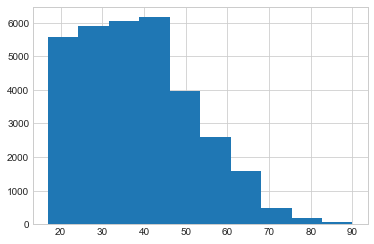

In [10]:
plt.hist(adult['Age']);

It's clear from this histogram that nobody in this particular dataset is over 90, so an upper bound of 90 would suffice.

However, it's important to note that **this approach does not satisfy differential privacy**. If we pick our clipping bounds by looking at the data, then the bounds themselves might reveal something about the data.

Typically, clipping bounds are decided either by using a property of the dataset that can be known without looking at the data (e.g. that the dataset contains ages, which are likely to lie between 0 and 125), or by performing differentially private queries to evaluate different choices for the clipping bounds.

To use the second approach, we typically set the lower bound to 0 and slowly increase the upper bound until the query's output stops changing (meaning we haven't included any new data by increasing the bound). For example, let's try computing the sum of ages for clipping bounds from 0 to 100, using the Laplace mechanism for each one to ensure differential privacy:

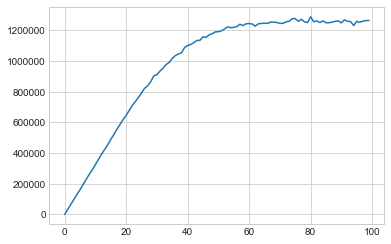

In [15]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)

epsilon_i = .01
plt.plot([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in range(100)]);

The total privacy cost for building this plot is $\epsilon = 1$ by sequential composition, since we do 100 queries each with $\epsilon_i = 0.01$. It's clear that the results level off around a value of `upper = 80`, so this is a good choice for the clipping bound.

We can use the same approach for data attributes from any numerical domain, but it helps to know something about the scale of the data in advance. For example, trying clipping values between 0 and 100 for yearly incomes would not work very well - we wouldn't even come close to finding a reasonable upper bound.